# Power Dissipation Index (PDI) Analysis

## Definitions 

PDI is an index that represents the destructive power of a storm combining together, intensity, duration, and frequency.

References: [Emanuel, 2005](ftp://texmex.mit.edu/pub/emanuel/PAPERS/NATURE03906.pdf) and [Emanuel, 2007](ftp://texmex.mit.edu/pub/emanuel/PAPERS/Factors.pdf)

In the references, Kerry Emanuel defines the index as:

$$PDI\equiv\int_0^{\tau}V^3_{max}dt~,$$

where $V_{max}$ is the maximum sustained wind speed, and $\tau$ is the lifetime of the storm event.



## The PDI Dataset

We're gonna use the PDI calculated by [National Oceanic & Atmospheric Administration (NOAA)](https://www.noaa.gov) which data is avaible at [Our World in Data](https://ourworldindata.org/grapher/cyclone-power-dissipation-index). It covers the North Atlantic, Caribbean and Gulf of Mexico storms.

The data has been smoothed through a five-year weighted average plotted at the center, in order to remove interannual variability. We're gonna o the same smooth with our climate dataset of Atlantic MDR.

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import scipy.stats as stats
from math import *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, HoltWintersResults
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
import datetime as dt
sns.set()
%matplotlib inline

In [95]:
raw_pdi = pd.read_csv('Datasets/cyclone-power-dissipation-index.csv')
raw_pdi.head()

,Entity,Code,Year,"Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)"
0,North Atlantic,NaN,1951,2.7846
1,North Atlantic,NaN,1952,2.3445
2,North Atlantic,NaN,1953,2.2639
3,North Atlantic,NaN,1954,2.4730
4,North Atlantic,NaN,1955,2.4041


In [96]:
raw_pdi.dtypes

Entity                                                   object
Code                                                    float64
Year                                                      int64
Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)    float64
dtype: object

In [97]:
PDI = raw_pdi[['Year','Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)']].rename(
    columns={'Year': 'Year','Cyclone Power Dissipation Index (PDI) (HUDRAT, NOAA)':'PDI'})
PDI = PDI.set_index('Year')

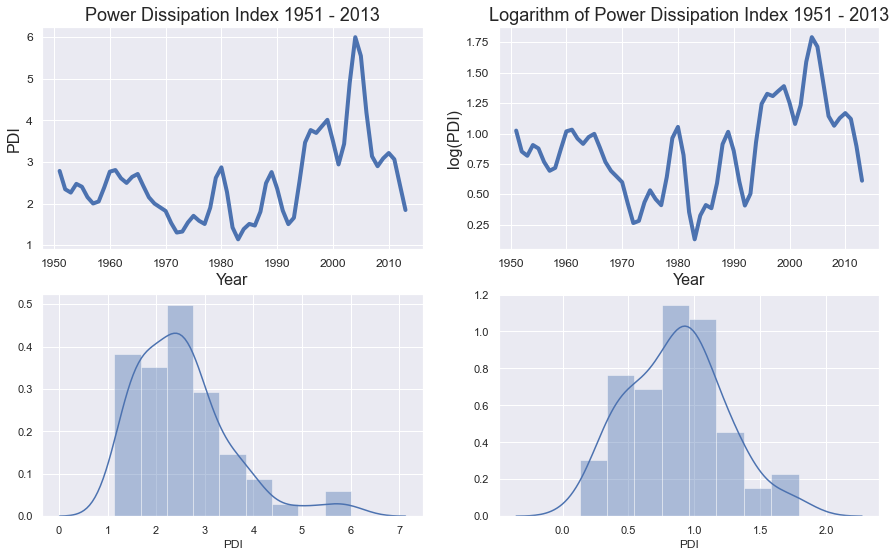

In [98]:
fig,axs = plt.subplots(2,2, figsize=(15,9))
axs[0,0].set_title("Power Dissipation Index 1951 - 2013",fontsize = 18)
axs[0,0].set_ylabel("PDI",fontsize = 16)
axs[0,0].set_xlabel("Year",fontsize = 16)
axs[0,0].tick_params(axis='both', which='major', labelsize=12)
axs[0,0].tick_params(axis='both', which='minor', labelsize=12)
axs[0,0].plot(PDI.index, PDI.PDI, lw = 4);
axs[0,1].set_title("Logarithm of Power Dissipation Index 1951 - 2013",fontsize = 18)
axs[0,1].set_ylabel("log(PDI)",fontsize = 16)
axs[0,1].set_xlabel("Year",fontsize = 16)
axs[0,1].tick_params(axis='both', which='major', labelsize=12)
axs[0,1].tick_params(axis='both', which='minor', labelsize=12)
axs[0,1].plot(PDI.index, np.log(PDI.PDI),lw = 4)
sns.distplot(PDI.PDI, ax=axs[1,0])
sns.distplot(np.log(PDI.PDI), ax=axs[1,1])

## Atlantic MDR Climate Data

Let's do the same smoothing operation in our "atlantic_mdr" dataset. We're gonna apply a 1–3–4–3–1 weighted average [Emanuel, 2007](ftp://texmex.mit.edu/pub/emanuel/PAPERS/Factors.pdf) on the data, to get out of interannual variability.

In [99]:
atlantic_mdr = pd.read_csv('./Datasets/atlantic_mdr.csv')

def smooth(col):
    n = len(col)
    new_col = np.zeros([n,1])
    w = np.array([[1,3,4,3,1]])
    
    for i in range(2,n-2):
        new_col[i] = w.dot(np.array(col[i-2:i+3]).reshape(-1,1))/12
    return new_col.ravel()


In [100]:
# atlantic_mdr = atlantic_mdr[(atlantic_mdr.Month>=8) & (atlantic_mdr.Month<=10)]
mdr_annual = atlantic_mdr.groupby('Year').agg({'sst':np.mean,
                                               'rhum':np.mean,
                                               'wspd':np.mean,
                                               'slp':np.mean,
                                               'vwnd':np.mean,
                                               'cldc':np.mean})


for col in mdr_annual.columns:
    mdr_annual.loc[:,col] = smooth(mdr_annual[col])
mdr_annual = mdr_annual.loc[1951:2013,:]
# mdr_annual

In [101]:
mdr_annual['PDI'] = np.array(PDI.PDI).reshape(-1,1)
# mdr_annual

## Analysing Correlation

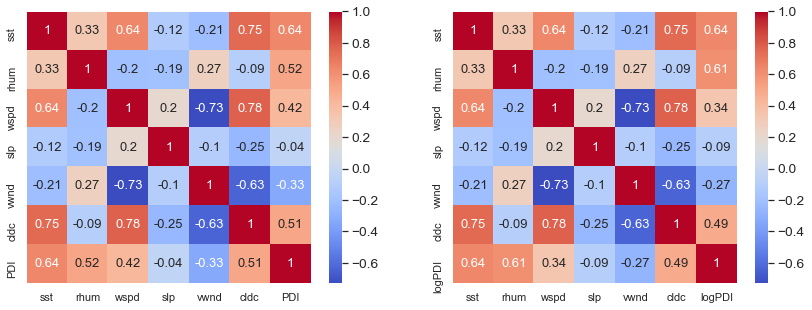

In [102]:
# corr = mdr_annual.corr()
# corr.style.background_gradient(cmap='coolwarm')

# corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')
f,axs = plt.subplots(1,2,figsize=(14,5))
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.heatmap(mdr_annual.corr().round(2),
    cmap='coolwarm',annot = True,annot_kws={"size": 13}, ax=axs[0]);

df = mdr_annual.copy()
df['PDI'] = np.log(df['PDI'])
df = df.rename(columns={"PDI":"logPDI"})
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.heatmap(df.corr().round(2),
    cmap='coolwarm',annot = True,annot_kws={"size": 13}, ax=axs[1]);
plt.show()

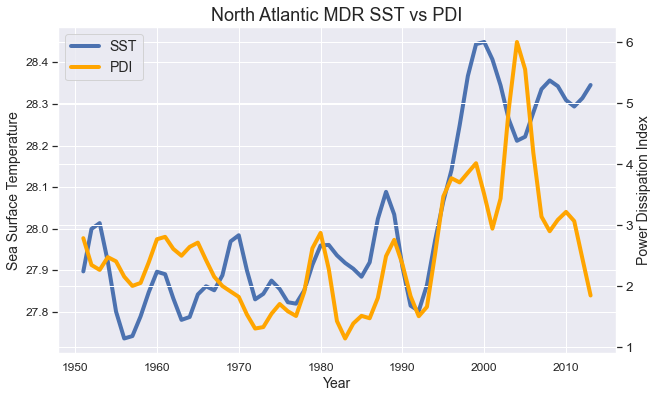

In [103]:
fig,ax = plt.subplots(figsize=(10,6))
plt.title("North Atlantic MDR SST vs PDI",fontsize = 18)

plt.xlabel("Year",fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

ax2 = ax.twinx()
ax.plot(mdr_annual.sst,lw = 4,label = "SST");
ax.set_ylabel("Sea Surface Temperature",fontsize=14)

ax2.plot(mdr_annual.PDI,lw=4,label="PDI",color = 'orange');
ax2.set_ylabel("Power Dissipation Index",fontsize=14)

fig.legend(loc="upper left",fontsize=14,bbox_to_anchor=(0,1), bbox_transform=ax.transAxes);

In [104]:
# sns.scatterplot(x=np.log(mdr_annual['sst']), y=np.log(mdr_annual['PDI']))
# sns.scatterplot(x=X.sst, y=mdr_annual['PDI'])

## Simple Linear Model

Quanto à trajetória do PDI, é observável uma leve tendência positiva.

Text(0.5, 1.0, 'Evolução do PDI com o tempo e a tendência de crescimento com uma reta')

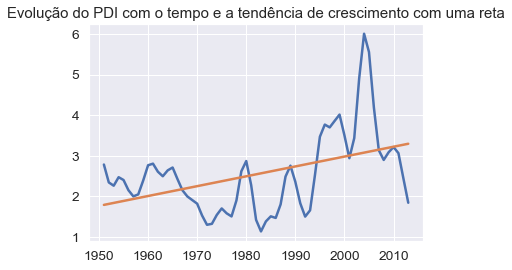

In [105]:
# Aparentemente o PDI cresceu:
X = mdr_annual.drop(columns="PDI") 
X = sm.add_constant(X)
Y = np.array(mdr_annual['PDI']).reshape(-1,1)
X['Year'] = np.array(X.index)
model = sm.OLS(Y, sm.add_constant(X['Year'])).fit()
plt.plot(PDI)
plt.plot(model.fittedvalues)
plt.title("Evolução do PDI com o tempo e a tendência de crescimento com uma reta")

Usando as covariáveis do dataset, podemos fazer um modelo onde achamos relação com a pressão ao nivel do mar (slp), a humidade (rhum) e a "cloudin.

In [106]:
# X['sst'] = np.log(X['sst'])
(xtrain, xtest, ytrain, ytest)  = train_test_split(X.drop(columns=["sst", "wspd", "vwnd", "Year"]), np.log(Y))
model = sm.OLS(ytrain, xtrain).fit()
ypred = model.predict(xtest) 
print("R2 nos dados separados para teste:",r2_score(ytest,ypred))
print(model.summary())

R2 nos dados separados para teste: 0.2268374488496503
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     51.26
Date:                Mon, 31 Aug 2020   Prob (F-statistic):           2.98e-14
Time:                        10:22:52   Log-Likelihood:                 14.019
No. Observations:                  47   AIC:                            -20.04
Df Residuals:                      43   BIC:                            -12.64
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

----

Pode parecer um pouco contraintuitivo a princípio não achar relação significativa da temperatura do mar e da intensidade (na verdade, a destrutibilidade, o PDI) dos furacões. Uma explicação plausivel para isso é que os dados de temperatura conseguem ser explicados pelas outras variáveis:

In [107]:
model = sm.OLS(X['sst'], X.drop(columns=['vwnd','wspd', 'Year', 'sst'])).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    sst   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     58.61
Date:                Mon, 31 Aug 2020   Prob (F-statistic):           1.08e-17
Time:                        10:22:52   Log-Likelihood:                 53.106
No. Observations:                  63   AIC:                            -98.21
Df Residuals:                      59   BIC:                            -89.64
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -177.9485     73.852     -2.410      0.0

----

## Time series Analysis

In [108]:
tsPDI = pd.DataFrame(Y, index = [dt.datetime(x, 1, 1) for x in mdr_annual.index], columns=["PDI"])
tsPDI.head()

,PDI
1951-01-01,2.7846
1952-01-01,2.3445
1953-01-01,2.2639
1954-01-01,2.4730
1955-01-01,2.4041


Vamos tratar agora a trajetória do PDI como uma série temporal. Inicialmente, vamos ajustar um modelo autorregressivo de ordem 2:

In [109]:
mod = sm.tsa.ARIMA(tsPDI, order=(2, 0, 0))
modfit = mod.fit()
# modfit.summary()

/home/gambitura/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


In [110]:
# fig, axs = plt.subplots(2,2, figsize = (10,4))
# plot_acf(modfit.resid, ax = axs[0, 0])
# plot_pacf(modfit.resid, ax = axs[0, 1])
# sm.qqplot(modfit.resid, dist=stats.norm, line="s", ax = axs[1, 0])
# sns.distplot(modfit.resid, ax = axs[1, 1])
# plt.show()# modfit.plot_diagnostics()

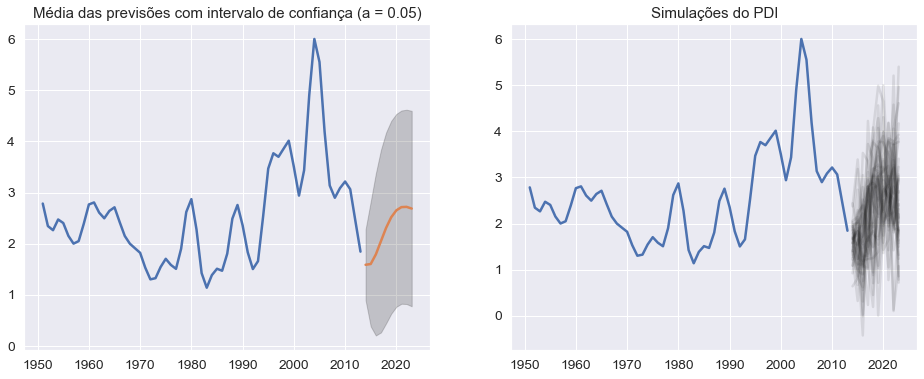

In [111]:
fig, axs = plt.subplots(1,2, figsize = (16,6))

# With CI:
axs[0].plot(tsPDI['PDI'])
# plt.plot(tsPDI['PDI'], axs = axs[0])
step = 10
forecast = modfit.forecast(step)
x = pd.date_range(dt.datetime(2013,1,1), freq="A", periods=step)
axs[0].plot(x, forecast[0])
axs[0].fill_between(x, forecast[2][:,0], forecast[2][:,1], 
                    color='k', alpha=.2)
#simulating some cenarios:
sims = np.zeros((500, step))
for i in range(500):
    sims[i] = np.random.normal(forecast[0], forecast[1])

axs[1].plot(tsPDI['PDI'])
for i in range(40):
    axs[1].plot(x, sims[i], color = "k", alpha=.1)

axs[0].set_title('Média das previsões com intervalo de confiança (a = 0.05)')
axs[1].set_title('Simulações do PDI')
plt.show()

Modelando o log da série:

In [112]:
tsLogPDI = tsPDI.apply(np.log)
#sm.tsa.stattools.adfuller(tsLogPDI['PDI']) ainda não é estacionaria a 5% de significancia
mod2 = sm.tsa.ARIMA(tsLogPDI, order=(2, 0, 0))
modfit2 = mod2.fit()
# modfit2.summary()

/home/gambitura/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


In [113]:
# fig, axs = plt.subplots(2,2, figsize = (10,4))
# plot_acf(modfit2.resid, ax = axs[0, 0])
# plot_pacf(modfit2.resid, ax = axs[0, 1])
# sm.qqplot(modfit2.resid, dist=stats.norm, line="s", ax = axs[1, 0])
# sns.distplot(modfit2.resid, ax = axs[1, 1])
# plt.show()

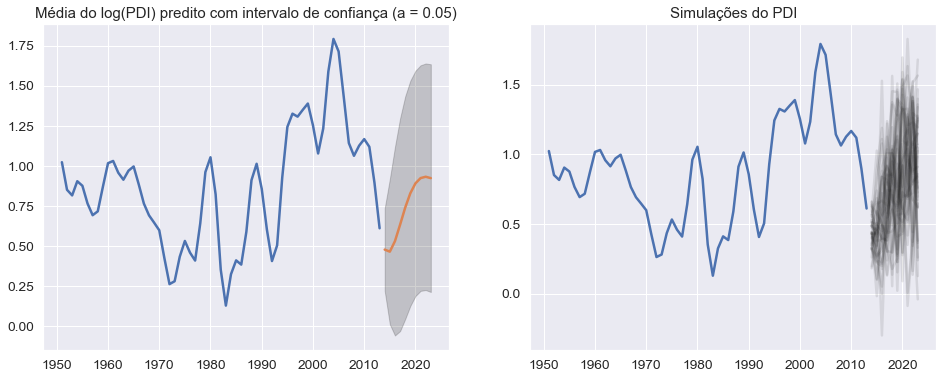

In [114]:
fig, axs = plt.subplots(1,2, figsize = (16,6))

# With CI:
axs[0].plot(tsLogPDI['PDI'])
# plt.plot(tsPDI['PDI'], axs = axs[0])
step = 10
forecast = modfit2.forecast(step)
x = pd.date_range(dt.datetime(2013,1,1), freq="A", periods=step)
axs[0].plot(x, forecast[0])
axs[0].fill_between(x, forecast[2][:,0], forecast[2][:,1], 
                    color='k', alpha=.2)
#simulating some cenarios:
sims = np.zeros((500, step))
for i in range(500):
    sims[i] = np.random.normal(forecast[0], forecast[1])

axs[1].plot(tsLogPDI['PDI'])
for i in range(40):
    axs[1].plot(x, sims[i], color = "k", alpha=.1) #teste de sanidade

axs[0].set_title('Média do log(PDI) predito com intervalo de confiança (a = 0.05)')
axs[1].set_title('Simulações do PDI')
plt.show()

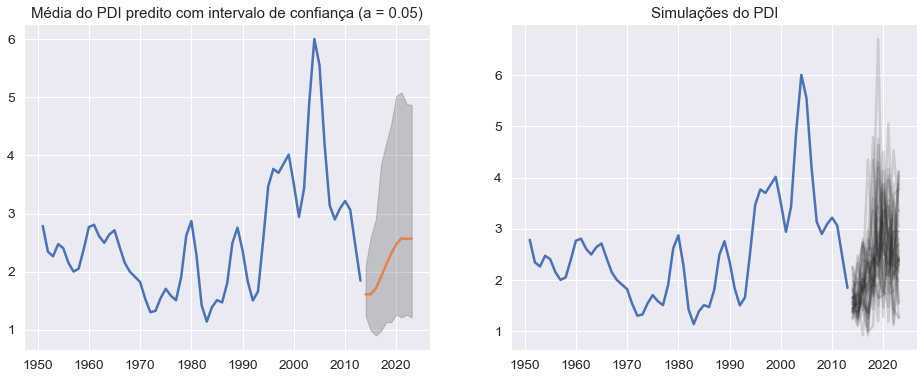

In [115]:
fig, axs = plt.subplots(1,2, figsize = (16,6))

# With CI:
axs[0].plot(tsPDI['PDI'])
# plt.plot(tsPDI['PDI'], axs = axs[0])
step = 10
forecast = modfit2.forecast(step)
x = pd.date_range(dt.datetime(2013,1,1), freq="A", periods=step)

#simulating some cenarios:
sims = np.zeros((1000, step))
for i in range(1000):
    sims[i] = np.exp(np.random.normal(forecast[0], forecast[1]))
# computing some CIs:
CIs = np.zeros((step,3))
for i in range(step):
    CIs[i] = np.quantile(sims[:,i], [0.025, 0.5, 0.975])
axs[0].plot(x, CIs[:,1])
axs[0].fill_between(x, CIs[:,0], CIs[:,2], 
                    color='k', alpha=.2)

axs[1].plot(tsPDI['PDI'])
for i in range(30):
    axs[1].plot(x, sims[i], color = "k", alpha=.15) #teste de sanidade

axs[0].set_title('Média do PDI predito com intervalo de confiança (a = 0.05)')
axs[1].set_title('Simulações do PDI')
plt.show()

In [116]:
# plt.plot(np.log(np.diff(np.log(mdr_annual['PDI'])) + 1))
# sm.tsa.stattools.adfuller(np.log(np.diff(np.log(mdr_annual['PDI'])) + 1))
tsTr = np.log(np.diff(np.log(tsPDI['PDI']))+1)

In [117]:
# terceiro modelo: log(delta(log(PDI))+1) como ARMA(2,1)
mod3 = sm.tsa.ARIMA(tsTr, order=(2,0,1))
modfit3 = mod3.fit()
# modfit3.summary()

In [118]:
# fig, axs = plt.subplots(2,2, figsize = (10,4))
# plot_acf(modfit3.resid, ax = axs[0, 0])
# plot_pacf(modfit3.resid, ax = axs[0, 1])
# sm.qqplot(modfit3.resid, dist=stats.norm, line="s", ax = axs[1, 0])
# sns.distplot(modfit3.resid, ax = axs[1, 1])
# plt.show()

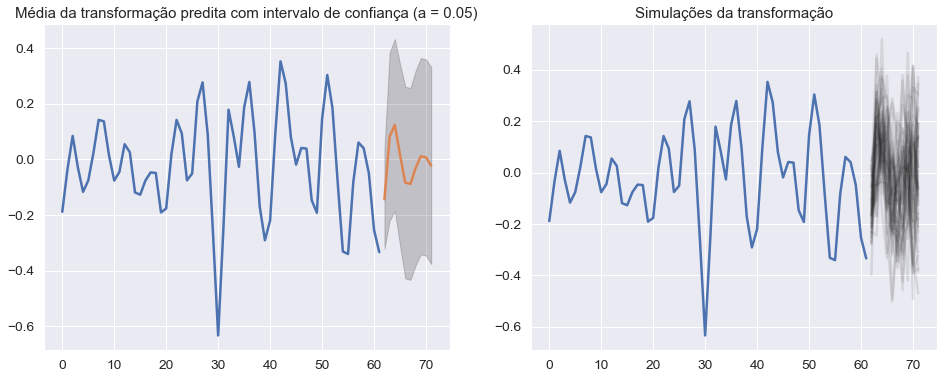

In [119]:
fig, axs = plt.subplots(1,2, figsize = (16,6))

# With CI:
axs[0].plot(tsTr)
# plt.plot(tsPDI['PDI'], axs = axs[0])
step = 10
forecast = modfit3.forecast(step)
x = range(len(tsTr), len(tsTr) + step)
axs[0].plot(x, forecast[0])
axs[0].fill_between(x, forecast[2][:,0], forecast[2][:,1], 
                    color='k', alpha=.2)
#simulating some cenarios:
sims = np.zeros((500, step))
for i in range(500):
    sims[i] = np.random.normal(forecast[0], forecast[1])

axs[1].plot(tsTr)
for i in range(40):
    axs[1].plot(x, sims[i], color = "k", alpha=.1) #teste de sanidade

axs[0].set_title('Média da transformação predita com intervalo de confiança (a = 0.05)')
axs[1].set_title('Simulações da transformação')
plt.show()

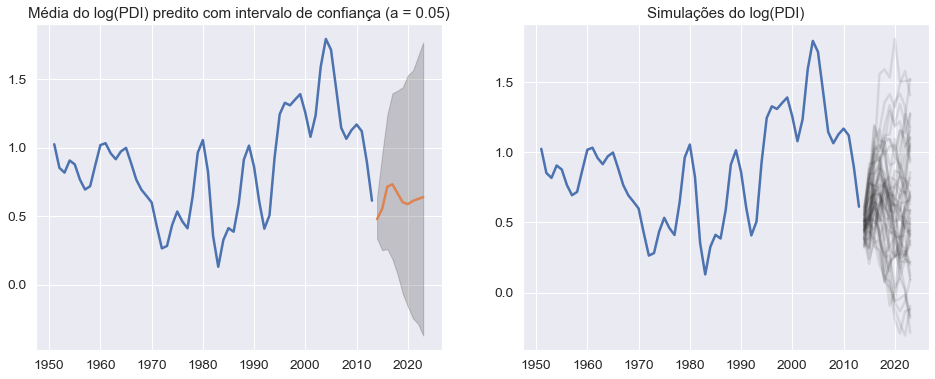

In [120]:
fig, axs = plt.subplots(1,2, figsize = (16,6))

# With CI:
axs[0].plot(tsLogPDI['PDI'])
# plt.plot(tsPDI['PDI'], axs = axs[0])
step = 10
forecast = modfit3.forecast(step)
x = pd.date_range(dt.datetime(2013,1,1), freq="A", periods=step)

#simulating some cenarios:
dsims = np.zeros((1000, step))
for i in range(1000):
    dsims[i] = np.exp(np.random.normal(forecast[0], forecast[1])) - 1
last = tsLogPDI["PDI"].values[-1]
for i in range(len(dsims)):
    dsims[i] = last + np.cumsum(dsims[i])
# computing some CIs:
CIs = np.zeros((step,3))
for i in range(step):
    CIs[i] = np.quantile(dsims[:,i], [0.025, 0.5, 0.975])
axs[0].plot(x, CIs[:,1])
axs[0].fill_between(x, CIs[:,0], CIs[:,2], 
                    color='k', alpha=.2)

axs[1].plot(tsLogPDI['PDI'])
for i in range(50):
    axs[1].plot(x, dsims[i], color = "k", alpha=.1) #teste de sanidade
    
axs[0].set_title('Média do log(PDI) predito com intervalo de confiança (a = 0.05)')
axs[1].set_title('Simulações do log(PDI)')
plt.show()

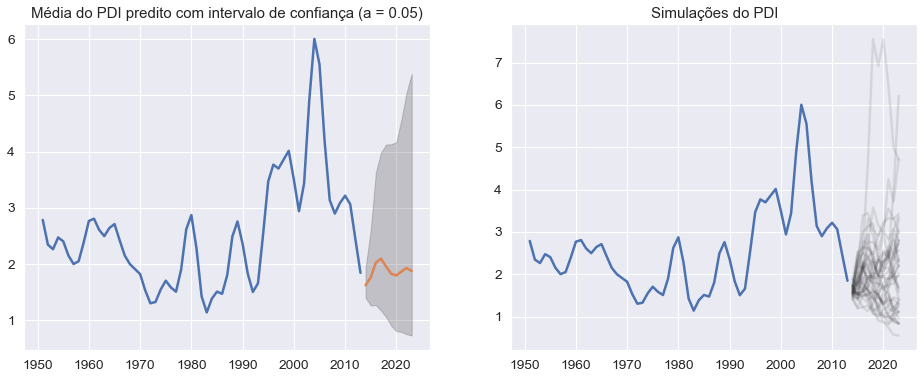

In [121]:
fig, axs = plt.subplots(1,2, figsize = (16,6))

# With CI:
axs[0].plot(tsPDI['PDI'])
# plt.plot(tsPDI['PDI'], axs = axs[0])
step = 10
forecast = modfit3.forecast(step)
x = pd.date_range(dt.datetime(2013,1,1), freq="A", periods=step)

#simulating some cenarios:
dsims = np.zeros((1000, step))
for i in range(1000):
    dsims[i] = np.exp(np.random.normal(forecast[0], forecast[1])) - 1
last = tsLogPDI["PDI"].values[-1]
for i in range(len(dsims)):
    dsims[i] = np.exp(last + np.cumsum(dsims[i]))
# computing some CIs:
CIs = np.zeros((step,3))
for i in range(step):
    CIs[i] = np.quantile(dsims[:,i], [0.025, 0.5, 0.975])
axs[0].plot(x, CIs[:,1])
axs[0].fill_between(x, CIs[:,0], CIs[:,2], 
                    color='k', alpha=.2)

axs[1].plot(tsPDI['PDI'])
for i in range(40):
    axs[1].plot(x, dsims[i], color = "k", alpha=.1) #teste de sanidade

axs[0].set_title('Média do PDI predito com intervalo de confiança (a = 0.05)')
axs[1].set_title('Simulações do PDI')
plt.show()

----

----

## Count

  Medir destrutibilidade do furacão não é coisa trivial; não basta olhar o PDI visto que os nossos dados de PDI podem estar [errados](https://arxiv.org/abs/physics/0601050) por medições inconsistentes de velocidade até os anos 90, onde começamos a ter um comportamento anômalo do ENSO; além da dinâmica sazonal de correntes termosalínicas gerarem sazonalidade nas temperaturas entre decádas (Atlantic Multidecadal Oscilation, AMO). Outras alternativas comumente consideradas são a de contagem de furacões no ano e de tamanho de cada furacão; cada uma delas com seus problemas particulares. Abaixo, fazemos um modelo simples de GLM para contagem usando como preditores as covari
  
  

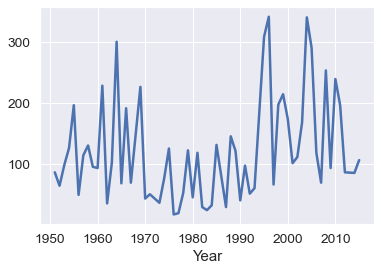

In [122]:
data = pd.read_csv('Datasets/data_atl_merged2.csv',parse_dates=['Date'])
data = data[['ID', 'Name', 'Date','Year', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'sst', 'rhum',
       'wspd', 'slp', 'cldc']]
def category(mw):
    if mw>=137:
        return "Category 5"
    elif mw>=113:
        return "Category 4"
    elif mw>=96:
        return "Category 3"
    elif mw>=83:
        return "Category 2"
    elif mw>=64:
        return "Category 1"
    elif mw>=34:
        return "Tropical Storm"
    else:
        return "Tropical Depression"
cat_id = data.groupby('ID')['Maximum Wind'].max().apply(category)
data.loc[:,'Category']=data.ID.apply(lambda x:cat_id[x])
# data.groupby('Category')['ID'].count().plot.bar();
major_df = data[data.Category.apply(lambda x: 0 if x[-1]=='m' else int(x[-1]))>=3]
major_df.groupby('Year')['ID'].count().plot()
#sm.tsa.stattools.adfuller(count)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     ID   No. Observations:                   60
Model:                            GLM   Df Residuals:                       54
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -347.61
Date:                Mon, 31 Aug 2020   Deviance:                       26.626
Time:                        10:22:58   Pearson chi2:                     26.3
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -146.2316    147.049     -0.994      0.3

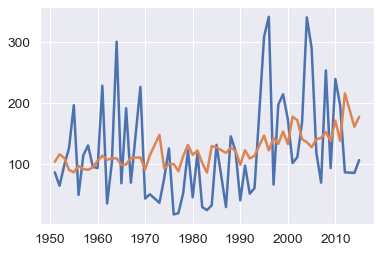

In [123]:
count = major_df.groupby("Year")["ID"].count()
X = pd.pivot_table(major_df, index="Year", values=["sst", "rhum", "wspd", "slp", "cldc"])
X['Y'] = X.index.values
countModel = sm.GLM(count, sm.add_constant(X), family=sm.families.NegativeBinomial())
countFit = countModel.fit()
print(countFit.summary()) #descomente para ver o sumario do ajuste
plt.plot(count)
plt.plot(countFit.predict(sm.add_constant(X)))
plt.show()